<a href="https://colab.research.google.com/github/wtglad/signed-area-causal-inference/blob/main/Signed%20Area%20Causal%20Discovery%20-%20Example%20Workflow%20(4%20Species%20System).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install signatory==1.2.4.1.7.1 --no-cache-dir --force-reinstall

     |████████████████████████████████| 61 kB 9.4 MB/s 
  Created wheel for signatory: filename=signatory-1.2.4.1.7.1-cp37-cp37m-linux_x86_64.whl size=7533684 sha256=e407fe557d681c22e7e8a7bda481b4d3bbcc4972ccaddea3a8badd7d778f9a88
  Stored in directory: /tmp/pip-ephem-wheel-cache-1_7lnp8h/wheels/fb/2d/23/eebc83e1c8668c2193faf4e9eb66a34c8357b9ab9cfc49775d
Successfully built signatory


In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import signatory
from itertools import product
import torch
from sklearn.preprocessing import MinMaxScaler
import scipy.stats
from progressbar import ProgressBar

# Helper functions

In [3]:
def preprocess_df(df, features):

  # Scale features by setting min/max difference to 1 and centering to zero mean

  scaler = MinMaxScaler()
  df[features] = scaler.fit_transform(df[features])
  
  for i in features:
    df[i] = df[i] - df[i].mean()

  df = df.dropna()
  df = df.reset_index(drop=True)
  df['t'] = df.index
  
  return df


In [4]:
def conf_seq(t, alpha, mu, sigma, rho=1):
  
  pm = np.array([+1, -1])
  
  conf_seq_ub, conf_seq_lb = mu + ((pm * sigma) * np.sqrt(((2 * (t * (rho ** 2) + 1))/((t ** 2) * (rho ** 2))) *
                                                          np.log((np.sqrt(t * (rho ** 2) + 1))/(alpha / 2))))
  
  return conf_seq_ub, conf_seq_lb

In [5]:
def check_in_bounds(signed_area_value, upper_bound, lower_bound):
  if signed_area_value > upper_bound:
    return 1
  elif signed_area_value < lower_bound:
    return -1
  else:
    return 0

In [6]:

def shuffled_signed_area_test(df, path_length, features, n_shuffles, plot_figures=False):
  
  # Create list of feature pairs
  pairwise_signature_terms = []
  sig_features = features.copy()

  for prod in product(features, features):
    sig_features.append(prod)
    if prod[0] != prod[1]:
      pairwise_signature_terms.append(prod)

  # Compute depth 1 and 2 path signatures and signed areas for original time series 
  data = []

  for i in df.index[path_length:]:
      path_subset = df.iloc[i-path_length:i]
      data.append(path_subset[features].to_numpy())

  depth = 2
  path = torch.Tensor(data)

  signature = signatory.signature(path, depth)
  sig_df = pd.DataFrame(signature.numpy())
  sig_df.columns = ['S' + str(i) for i in sig_features]


  for perm in pairwise_signature_terms:
    sig_df['A(' + perm[0] + ', ' + perm[1] + ')'] = 0.5 * (sig_df["S('" + perm[0] +"', '" + perm[1] + "')"] - sig_df["S('" + perm[1] + "', '" + perm[0] + "')"])

  sig_df = sig_df.merge(df.iloc[path_length:].reset_index(drop=True), left_index=True, right_index=True)

  # Compute signed area for n_shuffles 
  shuffled_signatures = pd.DataFrame()
  
  pbar = ProgressBar()

  for shuffle in pbar(range(n_shuffles)):
    df_shuffled = pd.DataFrame()
    for feature in features:
      df_shuffled[feature] = df[feature].sample(frac=1).reset_index(drop=True)
    
    shuffled_data = []

    for i in df_shuffled.index[path_length:]:
        path_subset = df_shuffled.iloc[i-path_length:i]
        shuffled_data.append(path_subset[features].to_numpy())

    path = torch.Tensor(shuffled_data)
    signature = signatory.signature(path, depth)
    shuffled_sig_df = pd.DataFrame(signature.numpy(), columns =  ['S' + str(i) for i in sig_features])
    shuffled_sig_df['shuffle_index'] = shuffle
    shuffled_sig_df['t'] = df.iloc[path_length:]['t'].reset_index(drop=True)
    

    for perm in pairwise_signature_terms:
        shuffled_sig_df['A(' + perm[0] + ', ' + perm[1] + ')'] = 0.5 * (shuffled_sig_df["S('" + perm[0] + "', '" + perm[1] + "')"] - shuffled_sig_df["S('" + perm[1] + "', '" + perm[0] + "')"])

    shuffled_signatures = shuffled_signatures.append(shuffled_sig_df, ignore_index=True)

  area_columns = [i for i in sig_df.columns.tolist() if 'A(' in i]
  
  # Compute confidence sequences for each pairwise term based on aggregated shuffles
  agg_shuffles = pd.DataFrame()

  for area_col in area_columns: 
    agg_shuffles[area_col] = shuffled_signatures.groupby('t').agg({area_col:'mean'})[area_col]
  
    # Compute cumulative mean and standard deviation and use to create confidence sequence lower and upper bounds
    cumulative_ub = []
    cumulative_lb = []

    for idx in agg_shuffles.index:
      ub, lb = conf_seq(idx, alpha=0.05, mu=agg_shuffles.iloc[:idx][area_col].mean(), sigma=shuffled_sig_df[shuffled_sig_df['t'] <= idx][area_col].std())
  
      cumulative_lb.append(lb)
      cumulative_ub.append(ub)

    agg_shuffles[area_col + '_seq_lb'] = cumulative_lb
    agg_shuffles[area_col + '_seq_ub'] = cumulative_ub

  agg_shuffles = agg_shuffles.reset_index(drop=True)
  sig_df = sig_df.merge(agg_shuffles, suffixes=('', '_shuffled'), left_index=True, right_index=True).dropna(how='any')

  # Compute shuffled signed area deviation at each time point and compute sum for entire series /len(series)
  ssad_summary = []

  for area_col in area_columns: 
    sig_df[area_col + '_SSADt'] = sig_df.apply(lambda x: check_in_bounds(x[area_col], x[area_col + '_seq_ub'], x[area_col + '_seq_lb']), axis=1)
    ssad_summary.append([area_col, sig_df[area_col + '_SSADt'].sum() / len(sig_df)])

  ssad = pd.DataFrame(ssad_summary, columns = ['feature_pair', 'SSAD'])  

  if plot_figures:
    for i in area_columns: 

      plt.figure(figsize=(15,3.5))
      sns.lineplot(x=agg_shuffles.index, y=agg_shuffles[i], label='Shuffled Signed Area $\mu$')
      sns.lineplot(x=sig_df['t'], y=sig_df[i], label='Original Signed Area')
      plt.fill_between(agg_shuffles.index, agg_shuffles[i + '_seq_lb'], agg_shuffles[i + '_seq_ub'], color = 'k', alpha=0.1)
      plt.legend(loc='lower right')
      plt.title(i)
      plt.savefig(i + '.png')
      plt.show()

  return ssad, sig_df, agg_shuffles



In [51]:
def time_shifted_signed_area_test(df, tau_min, tau_max, orig_features):
   
  features = orig_features.copy()

  for i in range(tau_min, tau_max + 1):
    for feat in features:
      df[feat + '_' + str(-1 * i)] = df[feat].shift(i)

  df = df.dropna()

  results = pd.DataFrame()

  for feat in orig_features: 
    col_subset = [i for i in df.columns.tolist() if ((feat in i) and (len(i) > 1))]
    other_features = [i for i in orig_features if i != feat]
    
    for tau_features in col_subset:
      features = [tau_features]
      features.extend(other_features)

      data = df[features].to_numpy().reshape(1, len(df), len(features))
      depth = 2
      path = torch.Tensor(data)

      signature = signatory.signature(path, depth)
      sig_df = pd.DataFrame(signature.numpy())

      pairwise_signature_terms = []
      sig_features = features.copy()

      for prod in product(features, features):
        sig_features.append(prod)
        if prod[0] != prod[1]:
          pairwise_signature_terms.append(prod)

      sig_df.columns = ['S' + str(i) for i in sig_features]

      for pair in pairwise_signature_terms: 
        sig_df['A(' + str(pair[0]) + ', ' + str(pair[1]) + ')'] = 0.5 * (sig_df["S('" + str(pair[0]) + "', '" + str(pair[1]) + "')"] - sig_df["S('" + str(pair[1]) + "', '" + str(pair[0]) + "')"])

      area_columns = [i for i in sig_df.columns.tolist() if 'A(' in i]

      area_df = sig_df[area_columns].T.reset_index()
      area_df.columns = ['pair', 'signed_area']

      area_df[['var1', 'var2']] = area_df['pair'].str.extract(r"\((.*?)\)", expand=False).apply(lambda x: x.split(',')).to_list()

      area_df['var1'] = area_df['var1'].str.strip()
      area_df['var2'] = area_df['var2'].str.strip()

      results = results.append(area_df, ignore_index=True)

  results = results.drop_duplicates().reset_index(drop=True)

  results = results.drop_duplicates()
  results = results[~results['var2'].str.contains('_')]
  results = results[results['var1'].str.contains('_')]
  results = results.reset_index(drop=True)

  results['time_lag'] = results['var1'].apply(lambda x: int(x.split('_')[1]))
  results['variable'] = results['var1'].apply(lambda x: x.split('_')[0])

  return results

In [108]:
def tsavr_check(x):
  if x >= 1.1:
    return 1
  elif x <= 0.9:
    return -1
  else:
    return 0

In [118]:
def summarize_causal_discovery_results(tssa_results, ssad, confidence_threshold=0.5):
  # Compute time shifted variance ratio for negative/positive lime shifts
  tssa_results['lag_group'] = tssa_results['time_lag'].apply(lambda x: 'negative' if x < 0 else ('positive' if x > 0 else '')) 
  neg_tsavar = tssa_results[tssa_results['lag_group'] == 'negative'].groupby(['variable', 'var2']).agg({'signed_area':'var'})
  pos_tsavar = tssa_results[tssa_results['lag_group'] == 'positive'].groupby(['variable', 'var2']).agg({'signed_area':'var'})
  tsavr = neg_tsavar.merge(pos_tsavar, left_index=True, right_index=True, suffixes=('_neg', '_pos')).reset_index()
  tsavr['var_ratio'] = tsavr['signed_area_neg'] / tsavr['signed_area_pos']

  # Extract feature pair from SSAD table to join to TSAVR results
  ssad['var2'] = ssad['feature_pair'].apply(lambda x: x.split(',')[1].replace(')', '')).str.strip()
  ssad['var1'] = ssad['feature_pair'].apply(lambda x: x.split(',')[0].replace('A(', '')).str.strip()

  sdf = ssad[['var1', 'var2', 'SSAD']].merge(tsavr[['variable', 'var2', 'var_ratio']], left_on=['var1', 'var2'], right_on=['variable', 'var2']).drop('variable', axis=1)
  
  # If SSAD > confidence threshold and TSAVR > 1.1 suggests causal link 
  sdf['ssad_link'] = sdf['SSAD'].apply(lambda x: 1 if abs(x) > confidence_threshold else 0)
  sdf['tsavr_link'] = sdf['var_ratio'].apply(lambda x: tsavr_check(x))

  sdf['result'] = sdf[['ssad_link', 'tsavr_link']].sum(axis=1)
  sdf['causal_link_suggested'] = sdf['result'].apply(lambda x: 1 if x == 2 else 0)

  return sdf[['var1', 'var2', 'SSAD', 'var_ratio', 'ssad_link', 'tsavr_link', 'causal_link_suggested']]


# 4 species system 


## Data generation

In [7]:
y1 = [0.4]
y2 = [0.4]
y3 = [0.4]
y4 = [0.4]


for step in range(999):

  y1_next = y1[-1] * (3.9 - (3.9 * y1[-1]))
  y2_next = y2[-1] * (3.6 - (0.4 * y1[-1]) - (3.6 * y2[-1]))
  y3_next = y3[-1] * (3.6 - (0.4 * y2[-1]) - (3.6 * y3[-1]))
  y4_next = y4[-1] * (3.8 - (0.35 * y3[-1]) - (3.8 * y4[-1]))

  y1.append(y1_next)
  y2.append(y2_next)
  y3.append(y3_next)
  y4.append(y4_next)

In [8]:
df = pd.DataFrame(zip(y1, y2, y3, y4), columns = ['v', 'x', 'y', 'z'])
df['w'] = np.random.randn(len(df))


In [ ]:
# Save output and reload for subsequent iterations if consistency of white noise desired
#df.to_csv('raw_4species.csv', index=False)
#df = pd.read_csv('raw_4species.csv')

In [12]:
df

,v,x,y,z,w,t
0,-0.217397,-0.315381,-0.349981,-0.278588,-0.213351,0
1,0.391739,0.279869,0.301570,0.311995,0.135050,1
2,-0.406473,-0.499194,-0.480291,-0.500416,0.057622,2
3,0.121576,0.122578,0.216820,0.038380,0.028551,3
4,0.261821,-0.062158,-0.234476,0.112037,-0.247819,4
...,...,...,...,...,...,...
995,-0.290144,-0.592212,-0.529248,-0.062725,-0.218547,995
996,0.316836,-0.052395,0.165297,0.337382,0.125711,996
997,-0.170996,0.098450,-0.079166,-0.544898,0.131416,997
998,0.420543,0.080840,0.188535,-0.075852,0.038052,998


In [32]:
features = df.columns.tolist()
df = preprocess_df(df, features)

In [33]:
features.remove('t')

## Shuffled signed area deviation test

100% (1000 of 1000) |####################| Elapsed Time: 0:16:50 Time:  0:16:50


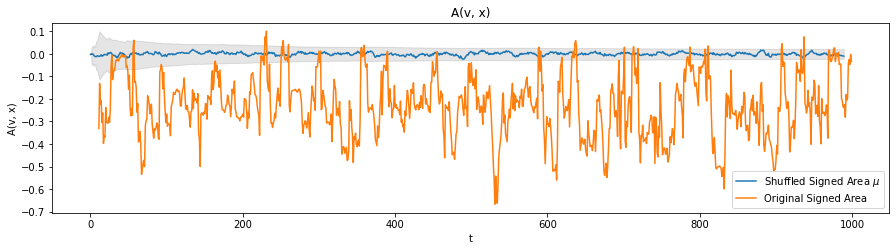

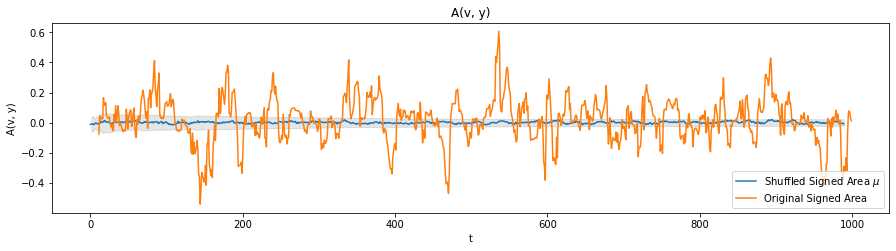

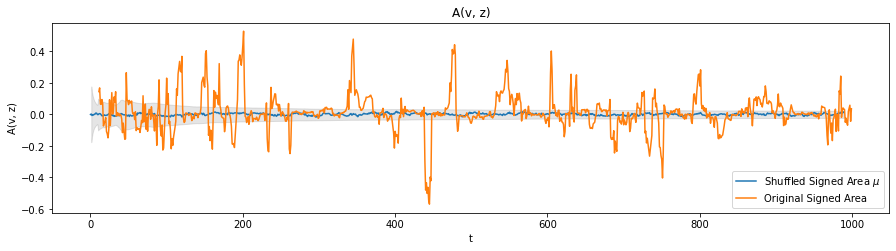

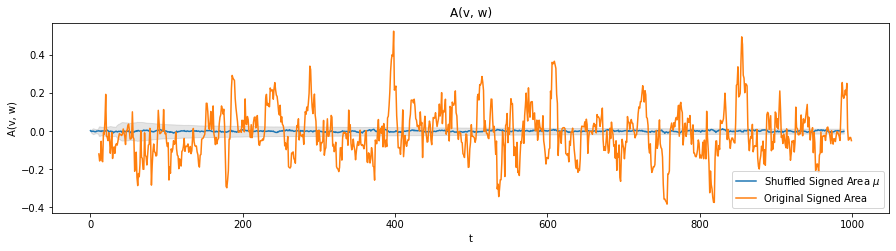

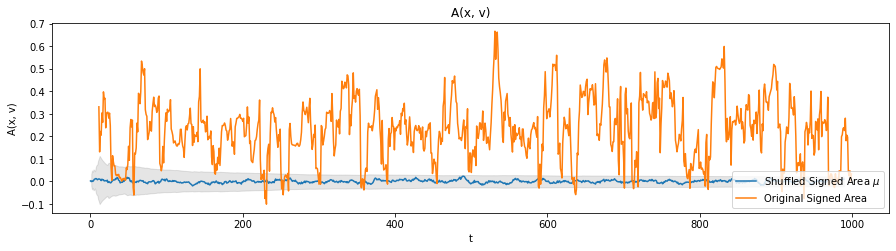

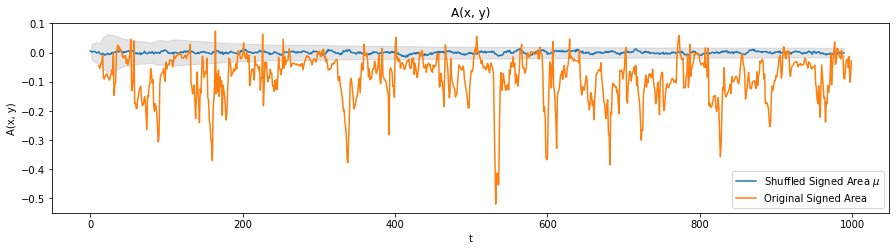

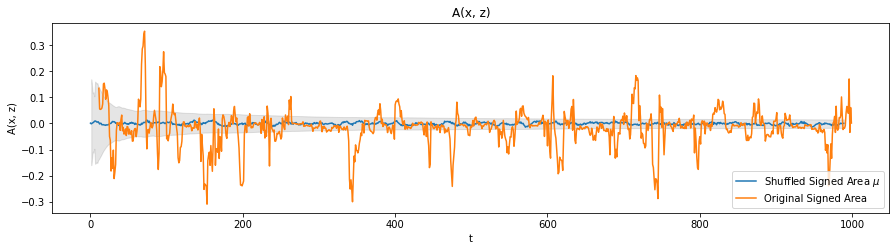

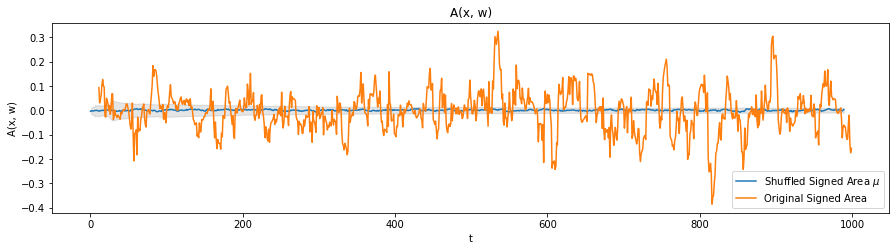

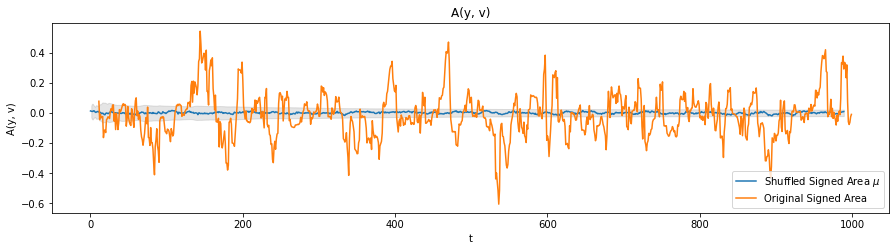

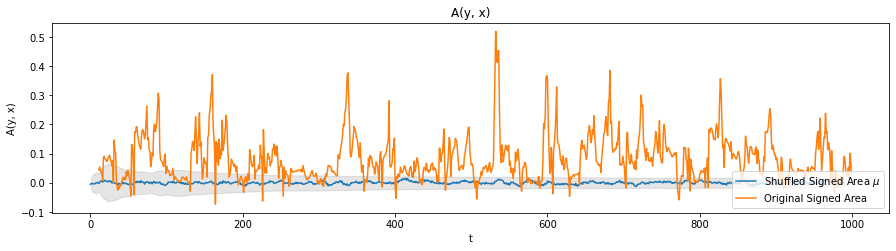

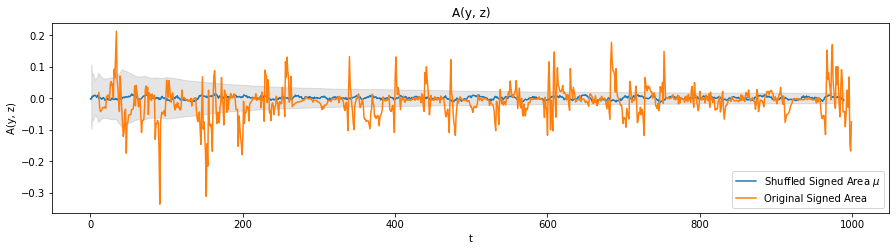

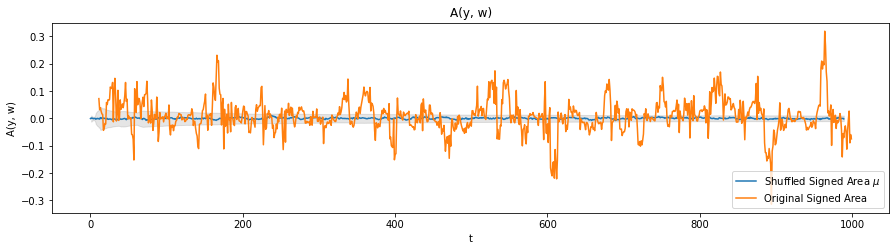

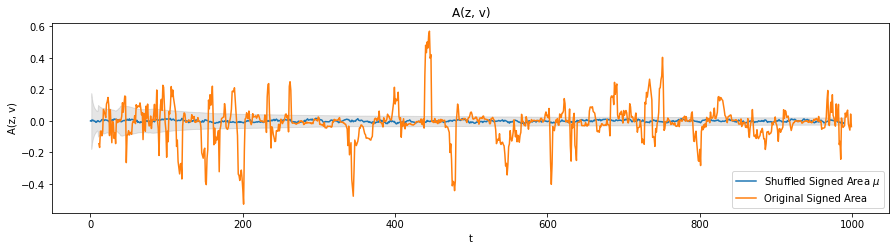

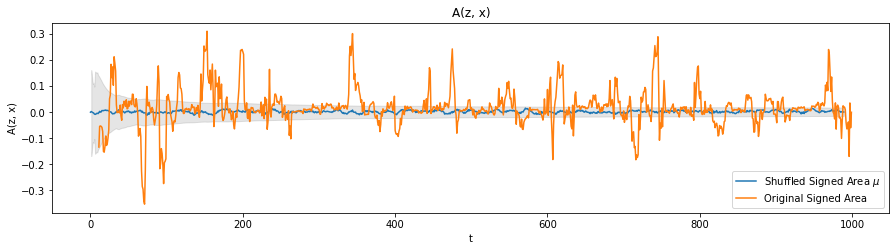

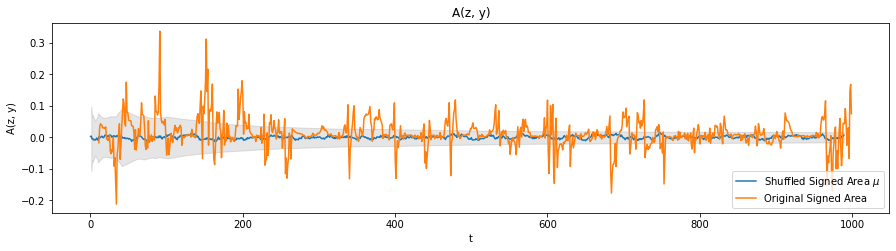

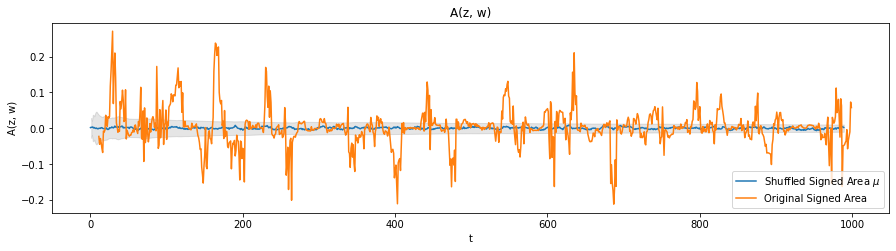

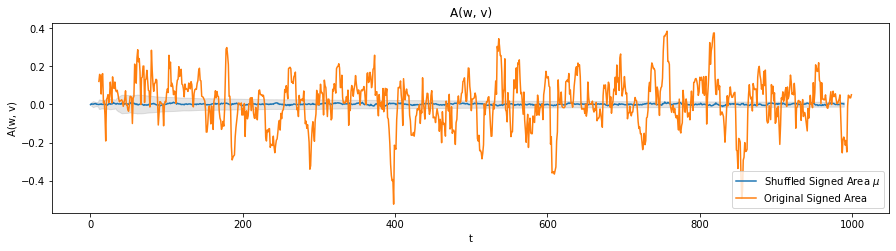

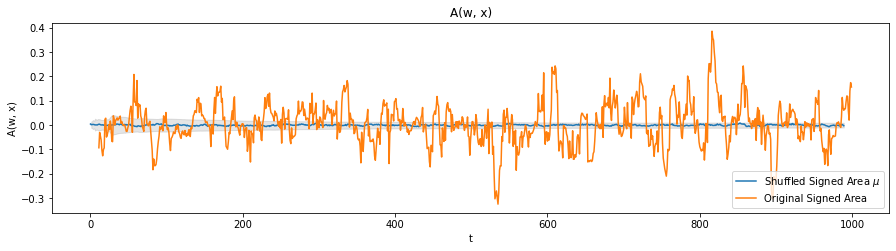

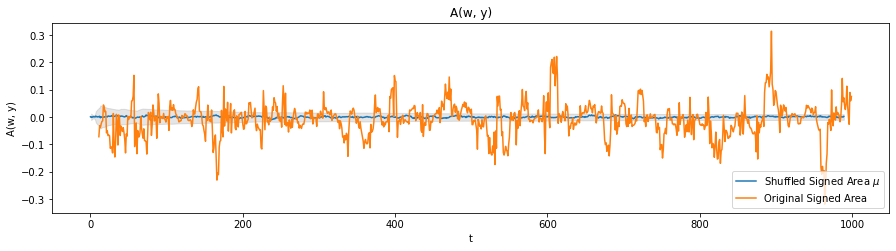

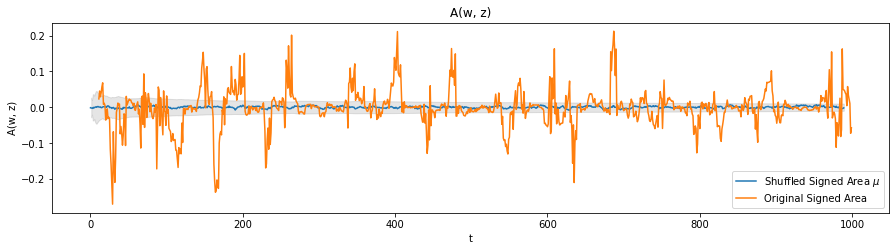

In [15]:
path_length = 10
n_shuffles = 1000 

ssad, shuff_sig_df, agg_shuffles = shuffled_signed_area_test(df, path_length, features, n_shuffles, plot_figures=True)

In [16]:
ssad

,feature_pair,SSAD
0,"A(v, x)",-0.886754
1,"A(v, y)",0.156724
2,"A(v, z)",0.078868
3,"A(v, w)",-0.148635
4,"A(x, v)",0.886754
5,"A(x, y)",-0.773509
6,"A(x, z)",-0.183013
7,"A(x, w)",-0.066734
8,"A(y, v)",-0.156724
9,"A(y, x)",0.773509


## Time-shifted signed area results & variance test

In [35]:
features = ['v', 'x', 'y', 'z', 'w']

In [100]:
tssa_results = time_shifted_signed_area_test(df[features], tau_min=-10, tau_max=10, orig_features=features)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


13.029431760191773


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


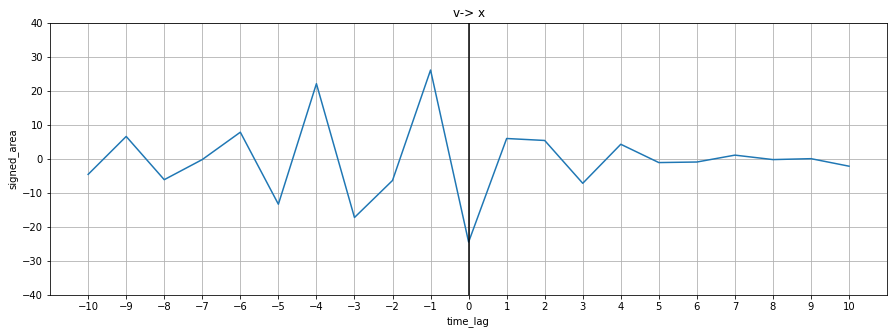

16.880825761883568


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


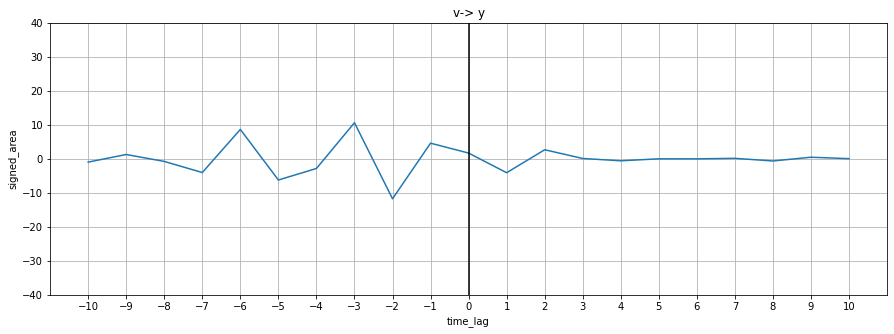

4.847059563798879


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


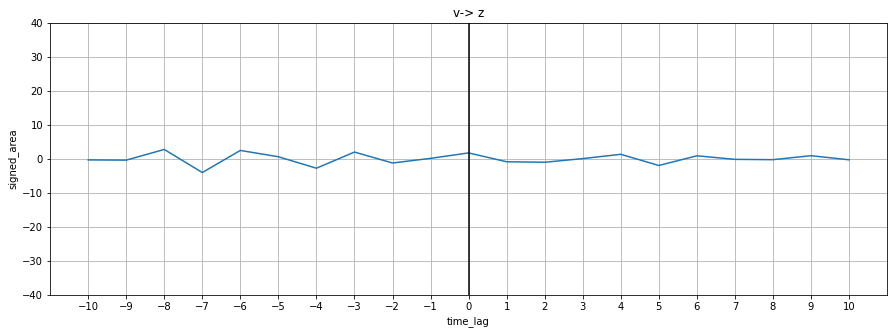

0.6164668438367781


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


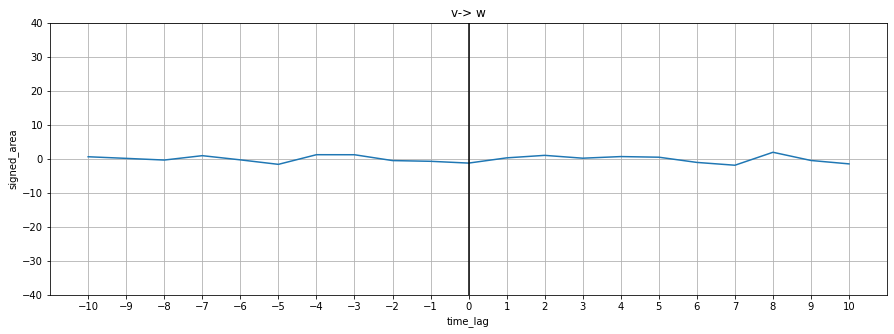

0.0771939425610617


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


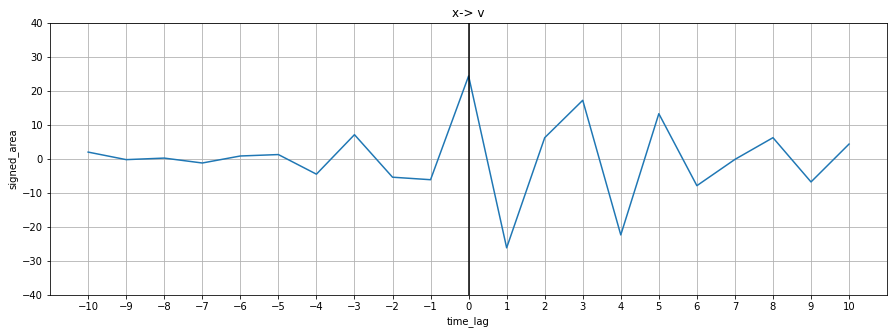

3.3237824845657022


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


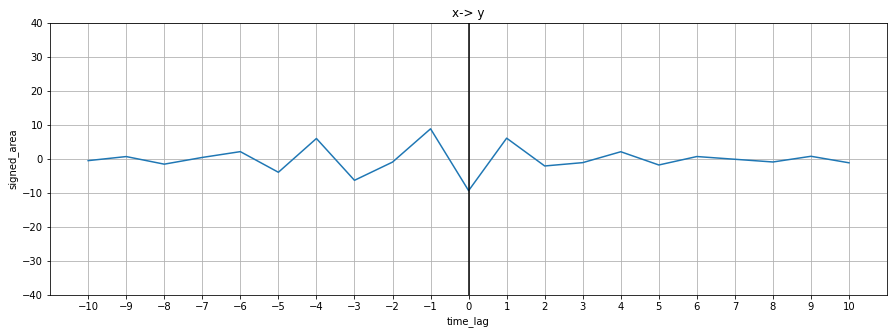

5.960314423492798


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


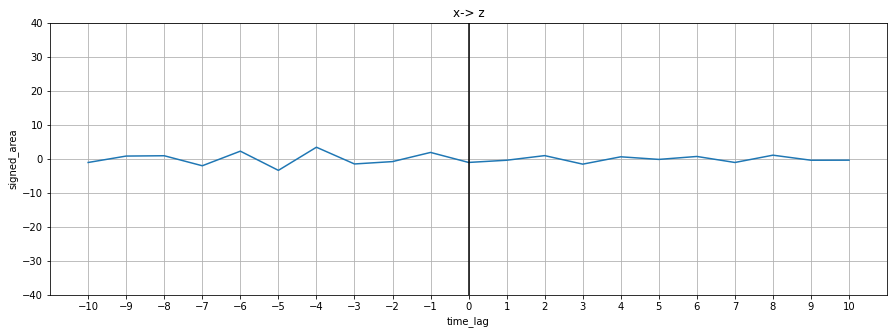

0.40790779340616534


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


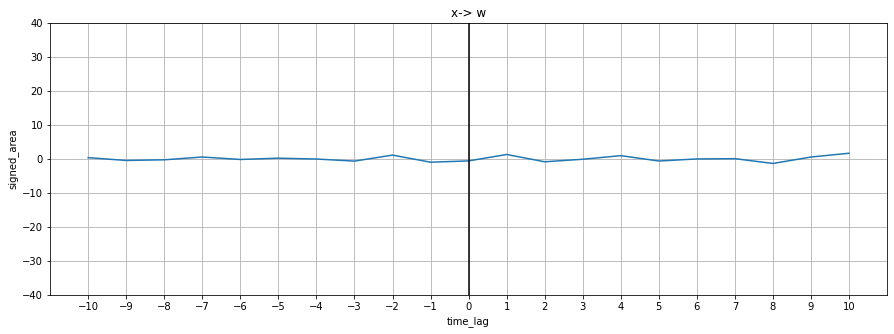

0.05477949655436927


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


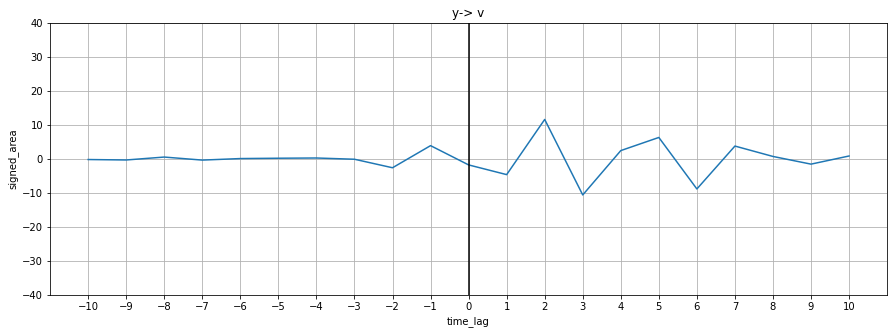

0.3036702178386901


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


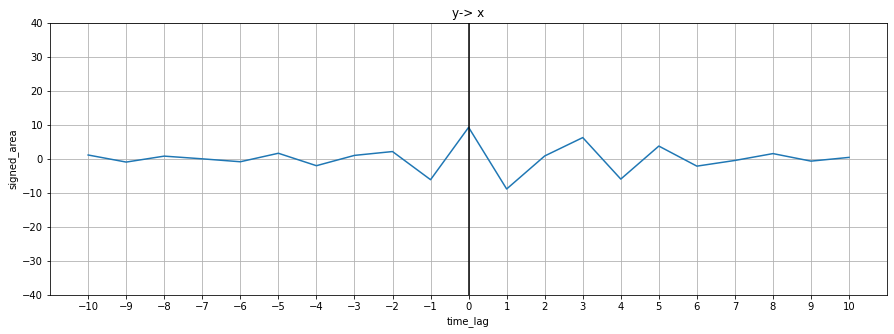

3.746057503341646


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


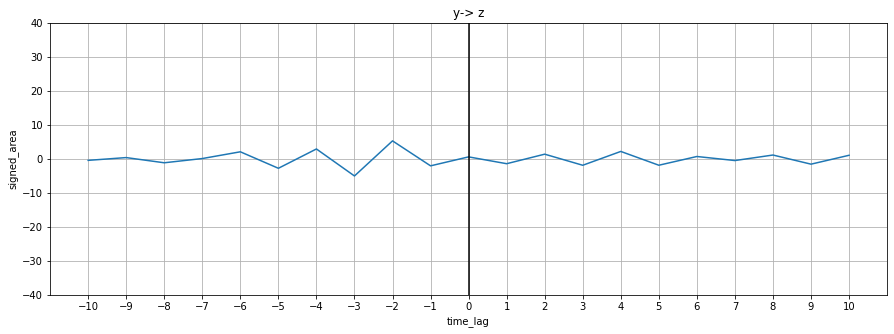

0.3518535252220395


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


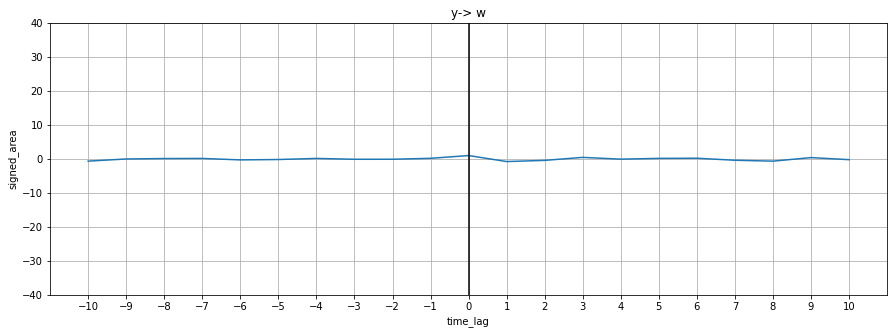

0.29478028275724744


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


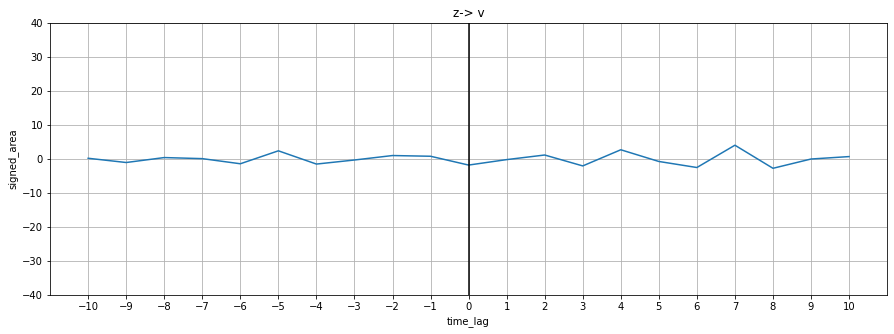

0.14955709186781904


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


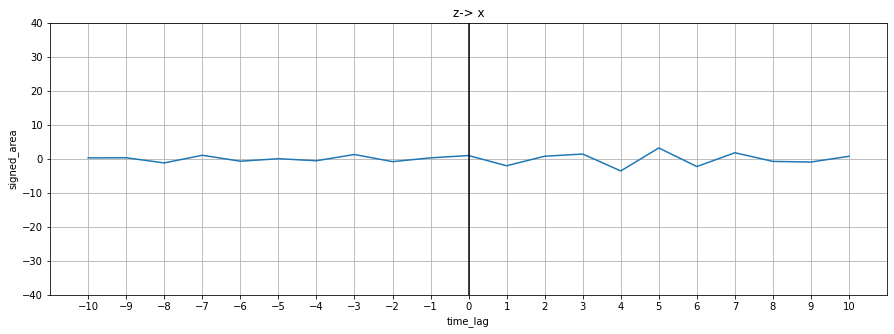

0.23242325941786654


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


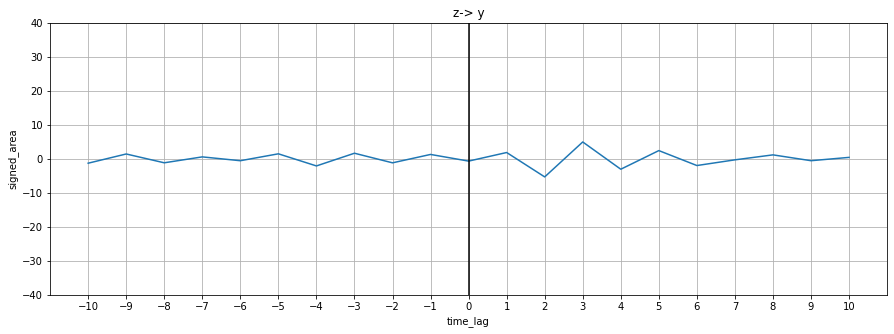

0.49267267337973447


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


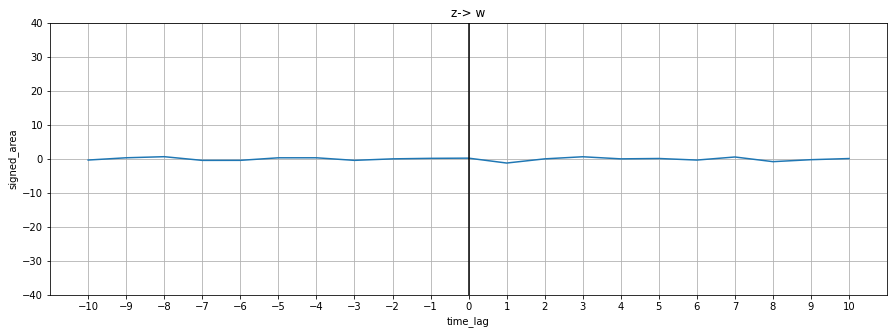

1.5156296435293812


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


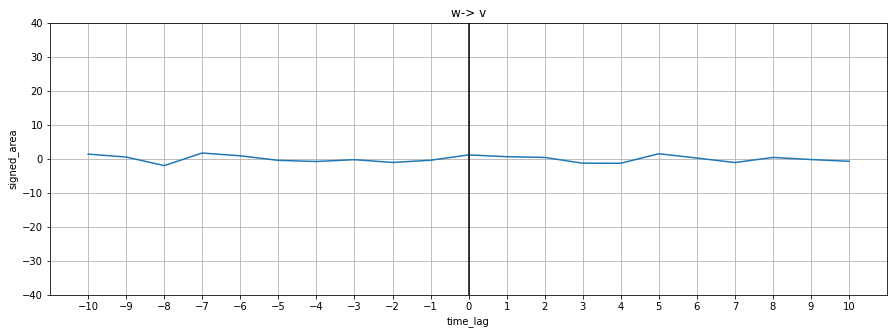

2.438737986681783


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


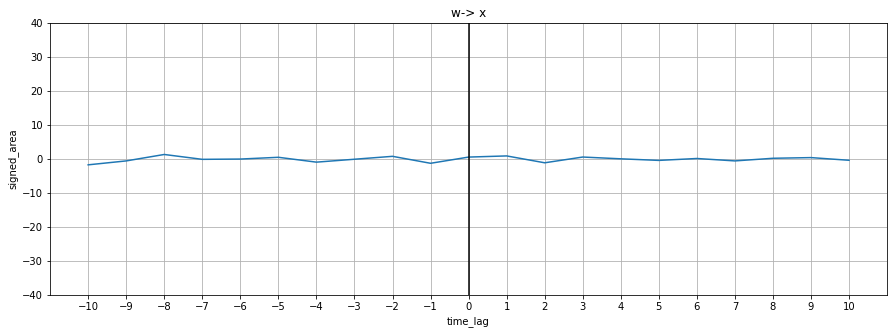

3.1152566241974493


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


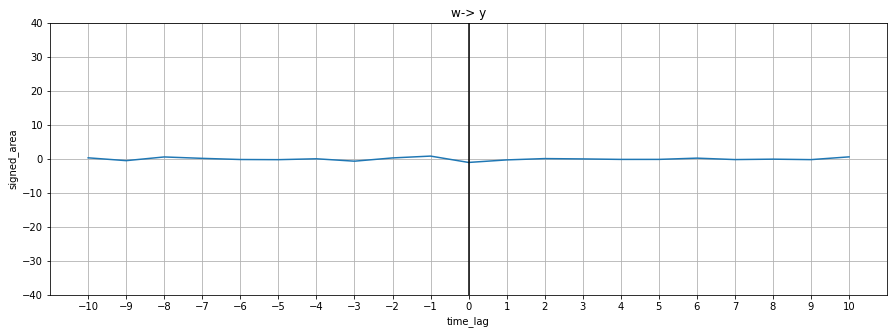

2.2648986434994667


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


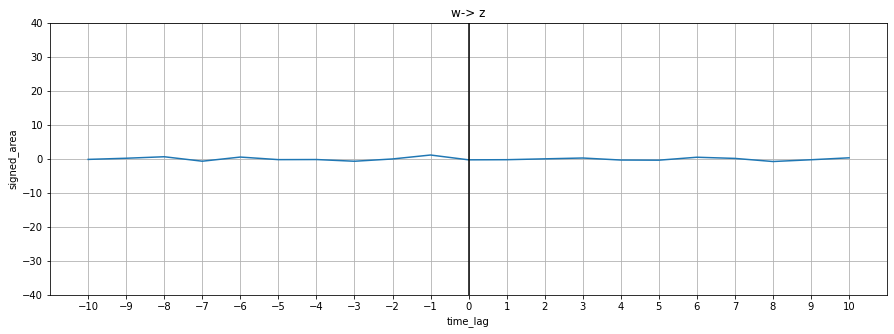

In [101]:
for i in features:
  for j in features:
    if i != j:
      results = tssa_results[(tssa_results['variable'] == i) & (tssa_results['var2'] == j)]
      results = results.sort_values(by='time_lag')

      neg_variance = results[results['time_lag'] < 0]['signed_area'].var()
      pos_variance = results[results['time_lag'] > 0]['signed_area'].var() 

      print(neg_variance / pos_variance)
      
      plt.figure(figsize=(15,5))
      plt.title(i + '-> ' + j)
      sns.lineplot(results['time_lag'], results['signed_area'])
      plt.ylim(-40, 40)
      plt.xticks(np.arange(-10, 11, 1))
      plt.axvline(0, c='k')
      plt.grid()
      plt.show()

## Summarize final results

In [119]:
summarize_causal_discovery_results(tssa_results, ssad, confidence_threshold=0.5)

,var1,var2,SSAD,var_ratio,ssad_link,tsavr_link,causal_link_suggested
0,v,x,-0.886754,13.029431,1,1,1
1,v,y,0.156724,16.880825,0,1,0
2,v,z,0.078868,4.847060,0,1,0
3,v,w,-0.148635,0.616467,0,-1,0
4,x,v,0.886754,0.077194,1,-1,0
5,x,y,-0.773509,3.323782,1,1,1
6,x,z,-0.183013,5.960314,0,1,0
7,x,w,-0.066734,0.407908,0,-1,0
8,y,v,-0.156724,0.054780,0,-1,0
9,y,x,0.773509,0.303670,1,-1,0
